In [182]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("Data/yearly-water-usage.csv", index_col=0, parse_dates=True)
df

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587


In [6]:
df.describe()

,Water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


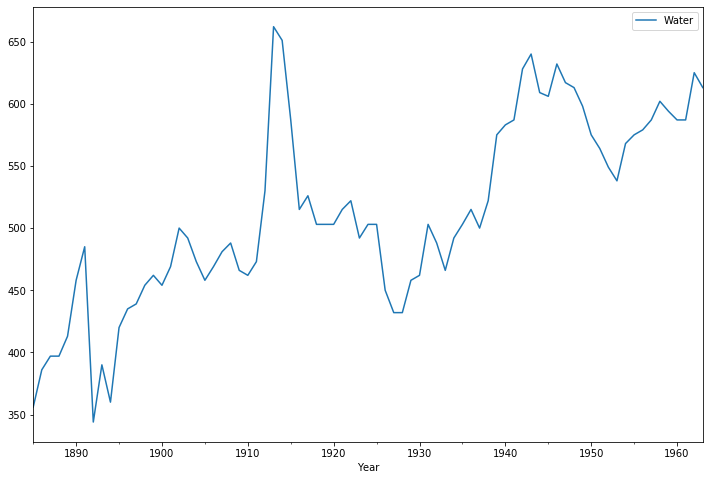

In [7]:
df.plot(figsize=(12,8));

* we will pretend that it is 1953 and withhold the last 10 years of data from analysis and model selection.

    * dataset.csv: Observations from 1885 to 1953 (69 observations).
    * validation.csv: Observations from 1954 to 1963 (10 observations).
   
The validation dataset is 12% of the original dataset.

In [8]:
data = df[:-10]
data

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1949-01-01,598
1950-01-01,575
1951-01-01,564


In [10]:
validation = df[-10:]
print(validation.info())
validation

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 1954-01-01 to 1963-01-01
Data columns (total 1 columns):
Water    10 non-null int64
dtypes: int64(1)
memory usage: 160.0 bytes
None


,Water
Year,
1954-01-01,568
1955-01-01,575
1956-01-01,579
1957-01-01,587
1958-01-01,602
1959-01-01,594
1960-01-01,587
1961-01-01,587
1962-01-01,625


### Test Strategy

Candidate models will be evaluated using walk-forward validation. The walk-forward validation will work as follows:

1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model.
3. A one-step prediction made.

In [11]:
X =data

train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

### Persistence

* The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction
for the observation at the next time step. 

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test['pred'] = test['Water'].shift()

#get first prediction from the last observation of train dataset
test['pred'][0] = train['Water'][-1]

test['error'] = test['Water'] - test['pred']


# report performance
rmse = sqrt(mean_squared_error(test['Water'], test['pred']))
print('RMSE: %.3f' % rmse)

RMSE: 21.975


C:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [14]:
test.head()

,Water,pred,error
Year,,,
1919-01-01,503,503.0,0.0
1920-01-01,503,503.0,0.0
1921-01-01,515,503.0,12.0
1922-01-01,522,515.0,7.0
1923-01-01,492,522.0,-30.0


* We now have a baseline prediction method and performance; now we can start digging into
our data.

In [17]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [18]:
dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.267303
p-value                         0.182730
#Lags Used                      2.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


* We can't reject the null hypothesis. It means that the process has  unit root and time series isn't stationary. Let's take a difference and test it again.

In [19]:
data_diff = data.diff().dropna()

dickey_fuller_test(data_diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.126719e+00
p-value                        8.593852e-08
#Lags Used                     1.000000e+00
Number of Observations Used    6.600000e+01
Critical Value (1%)           -3.533560e+00
Critical Value (5%)           -2.906444e+00
Critical Value (10%)          -2.590724e+00
dtype: float64


* We can reject the null hypothesis. It means that the process has no unit root, and in turn that the 1-lag differenced time series is stationary or does not have time-dependent structure.

* This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1. The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. The example below creates ACF and PACF plots for the series.

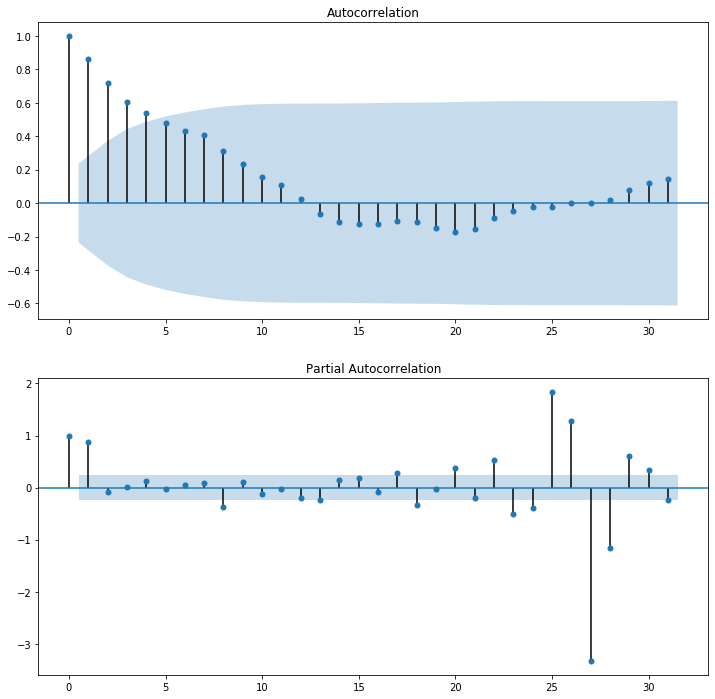

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1,figsize=(12, 12))

plot_acf(data, lags=31, ax=ax[0])
plot_pacf(data, lags=31, ax=ax[1])

plt.show()

* We couldn't get an obvious idea about p and q parameters for ARIMA!!

* ARIMA (4,1,1) from the book

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(data, order=(4,1,1), trend='c')

# Make predictions for last 35 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-35)

C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [31]:
rmse = sqrt(mean_squared_error(test.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 22.960


In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Water   No. Observations:                   69
Model:               SARIMAX(4, 1, 1)   Log Likelihood                -333.302
Date:                Mon, 27 Apr 2020   AIC                            680.604
Time:                        21:24:40   BIC                            696.141
Sample:                    01-01-1885   HQIC                           686.760
                         - 01-01-1953                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5842      0.662      0.883      0.377      -0.713       1.881
ar.L1          0.9138      0.151      6.033      0.000       0.617       1.211
ar.L2         -0.1236      0.155     -0.796      0.426      -0.428       0.181
ar.L3         -0.1274      0.176     -0.725      0.469      -0.472       0.217
ar.L4          0.1205      0.178      0.678      0.498      -0.228       0.469
ma.L1         -0.9991      5.563     -0.180      0.857     -11.903       9.905
sigma2      1023.6426   5545.551      0.185      0.854   -9845.437    1.19e+04
===================================================================================
Ljung-Box (Q):                       29.49   Jarque-Bera (JB):                91.56
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.02
Prob(H) (two-sided):                  0.04   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

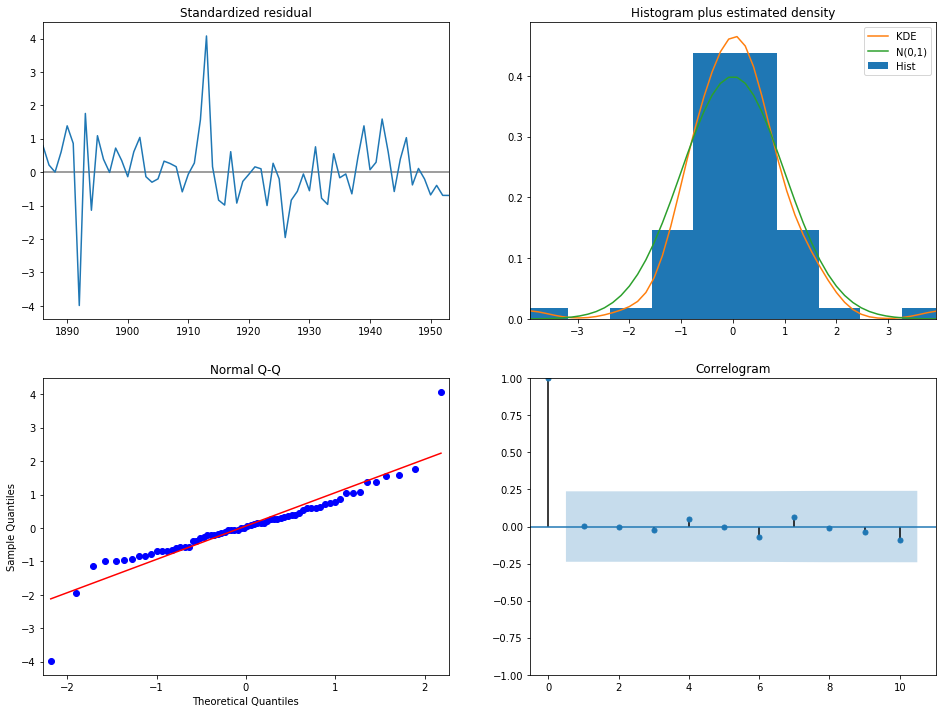

In [33]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

* ARIMA (2,1,0) from the book

In [65]:
model = SARIMAX(data, order=(2,1,0), trend='c')

# Make predictions for last 35 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-35)

In [66]:
rmse = sqrt(mean_squared_error(test.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 21.639


In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Water   No. Observations:                   69
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -336.882
Date:                Mon, 27 Apr 2020   AIC                            681.765
Time:                        22:34:38   BIC                            690.643
Sample:                    01-01-1885   HQIC                           685.283
                         - 01-01-1953                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8399      4.621      0.615      0.539      -6.218      11.897
ar.L1          0.0440      0.096      0.457      0.648      -0.145       0.233
ar.L2         -0.1040      0.102     -1.023      0.306      -0.303       0.095
sigma2      1176.2677    112.380     10.467      0.000     956.007    1396.528
===================================================================================
Ljung-Box (Q):                       35.99   Jarque-Bera (JB):                73.39
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

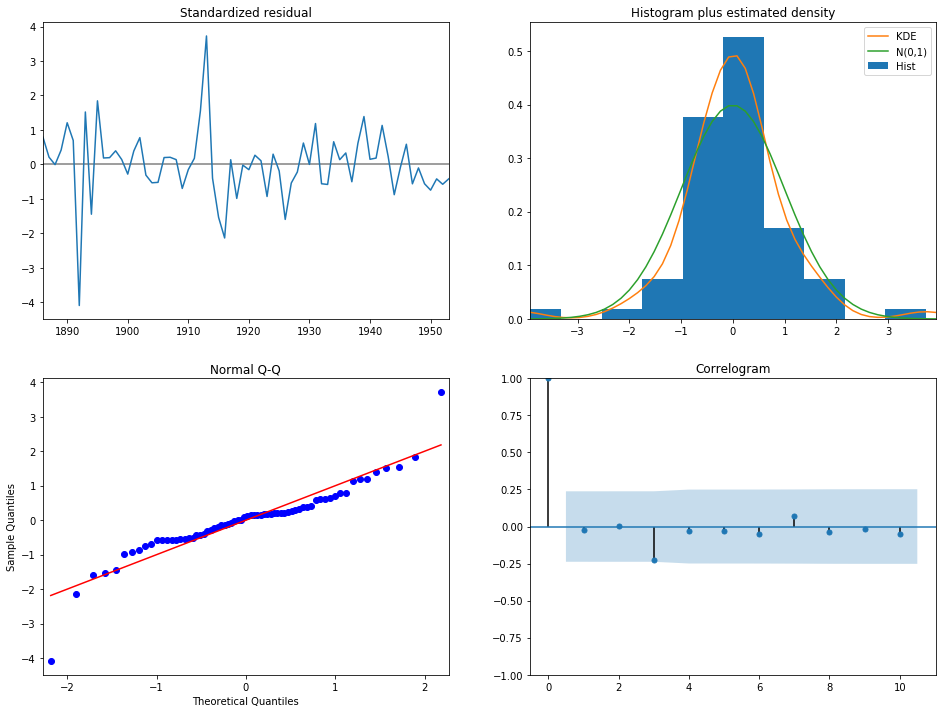

In [68]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

In [122]:
results.resid.describe()

count     69.000000
mean      10.698876
std       55.313384
min     -143.254618
25%      -10.849746
50%        5.144483
75%       23.678276
max      367.911329
dtype: float64

In [123]:
bias = results.resid.describe().loc['mean']
bias

10.69887573900702

### Searching over AIC and BIC

In [93]:
import warnings
warnings.filterwarnings("ignore")

aicVal = []

# Loop over AR order
for p in range(5):
    
    # Loop over MA order
    for q in range(5):
    
        # Fit model
        model = SARIMAX(data, order=(p,1,q))
        results = model.fit()
        
        aicVal.append([p, q, results.aic, results.bic])


In [94]:
opt = pd.DataFrame(aicVal, columns=["p", "q", "AIC", "BIC"])
opt.sort_values("AIC").head(20)

,p,q,AIC,BIC
0,0,0,677.032498,679.252005
3,0,3,678.470605,687.348636
1,0,1,678.861663,683.300679
5,1,0,678.891219,683.330234
15,3,0,679.178958,688.056988
11,2,1,679.917193,688.795224
7,1,2,680.170606,689.048637
10,2,0,680.222714,686.881237
2,0,2,680.354159,687.012682
4,0,4,680.463894,691.561432


* Let's try ARIMA(3,1,14)

In [46]:
model = SARIMAX(data, order=(3,1,14), trend='c')

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-35)

In [48]:
rmse = sqrt(mean_squared_error(test.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 21.402


In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Water   No. Observations:                   69
Model:              SARIMAX(3, 1, 14)   Log Likelihood                -333.763
Date:                Mon, 27 Apr 2020   AIC                            705.525
Time:                        22:21:34   BIC                            747.696
Sample:                    01-01-1885   HQIC                           722.235
                         - 01-01-1953                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -40.4558     40.318     -1.003      0.316    -119.478      38.566
ar.L1         -0.7045      0.053    -13.349      0.000      -0.808      -0.601
ar.L2         -0.6983      0.131     -5.346      0.000      -0.954      -0.442
ar.L3         -0.9937      0.102     -9.784      0.000      -1.193      -0.795
ma.L1          0.8090    261.503      0.003      0.998    -511.727     513.345
ma.L2          1.0060    818.101      0.001      0.999   -1602.442    1604.454
ma.L3          1.2191   1151.368      0.001      0.999   -2255.420    2257.858
ma.L4          0.3934   1148.012      0.000      1.000   -2249.669    2250.455
ma.L5          0.3529   1847.121      0.000      1.000   -3619.938    3620.644
ma.L6          0.1111    946.747      0.000      1.000   -1855.480    1855.702
ma.L7          0.2573     31.873      0.008      0.994     -62.213      62.727
ma.L8          0.1154    951.999      0.000      1.000   -1865.769    1866.000
ma.L9          0.3547   1803.425      0.000      1.000   -3534.293    3535.003
ma.L10         0.3926   1152.415      0.000      1.000   -2258.299    2259.084
ma.L11         1.2270   1142.545      0.001      0.999   -2238.120    2240.574
ma.L12         1.0152    808.400      0.001      0.999   -1583.419    1585.450
ma.L13         0.7978    258.679      0.003      0.998    -506.204     507.800
ma.L14         0.9886      0.201      4.929      0.000       0.595       1.382
sigma2       727.7406      0.242   3010.249      0.000     727.267     728.214
===================================================================================
Ljung-Box (Q):                       26.59   Jarque-Bera (JB):                51.98
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.16
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+23. Standard errors may be unstable.
"""

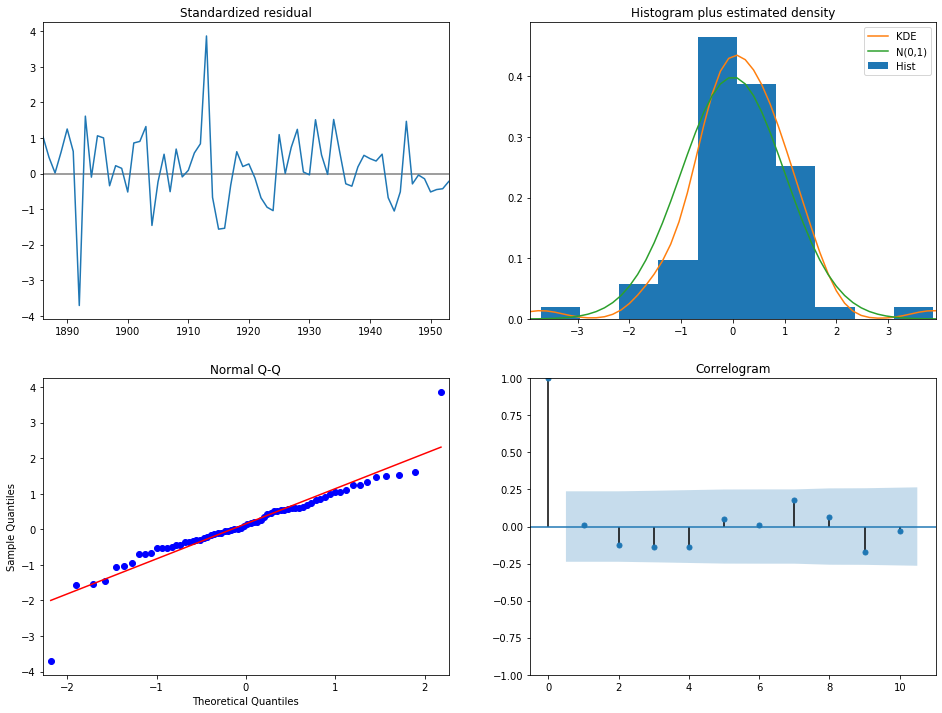

In [50]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

In [96]:
results.resid.describe()

count     69.000000
mean      10.901382
std       53.336216
min     -130.325441
25%       -9.609779
50%        5.959605
75%       22.012211
max      356.000000
dtype: float64

In [29]:
data_diff=data.diff().dropna()


In [97]:
import pmdarima as pm


results = pm.auto_arima(data, # data
                        
                        start_p=0, # initial guess for p
                        start_q=0, # initial guess for q
                        
                        seasonal=False, # is the time series seasonal
                       )

In [98]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   68
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -337.312
Method:                           css   S.D. of innovations             34.520
Date:                Mon, 27 Apr 2020   AIC                            678.625
Time:                        23:01:43   BIC                            683.064
Sample:                             1   HQIC                           680.384
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6765      4.186      0.639      0.523      -5.528      10.881
==============================================================================
"""

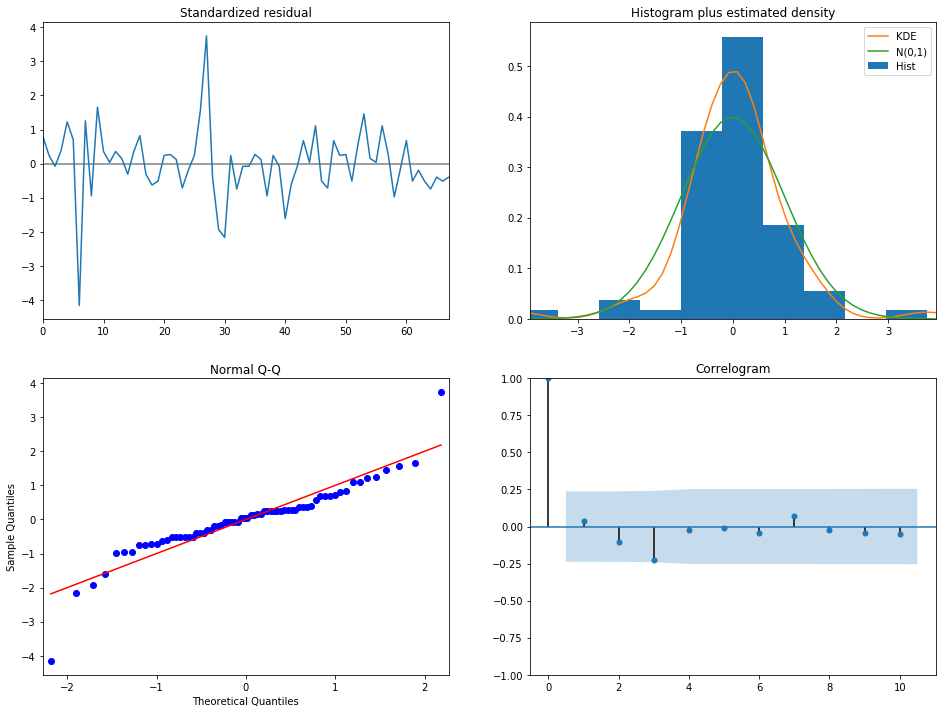

In [100]:
results.plot_diagnostics(figsize=(16,12));

In [101]:
# Instantiate model
model = SARIMAX(data, order=(0,1,0))

# Fit model
results = model.fit()

In [102]:
# Make in-sample prediction
forecast = results.get_prediction(start=-35)

In [103]:
rmse = sqrt(mean_squared_error(test.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 21.975


In [105]:
results.resid.describe()

count     69.000000
mean       7.797101
std       54.780197
min     -141.000000
25%      -15.000000
50%        4.000000
75%       15.000000
max      356.000000
dtype: float64

### boxcox transformation with ARIMA (3,1,14)

In [106]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from math import exp
from math import log

In [107]:
data_transformed, lam = boxcox(data.Water)

In [108]:
model = SARIMAX(data_transformed, order=(3,1,14), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_prediction(start=-35)

In [109]:
prediction =inv_boxcox(forecast.predicted_mean, lam)

In [110]:
rmse = sqrt(mean_squared_error(test.Water, prediction))
print('RMSE: %.3f' % rmse)

RMSE: 18.842


In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:              SARIMAX(3, 1, 14)   Log Likelihood                 -56.000
Date:                Mon, 27 Apr 2020   AIC                            149.999
Time:                        23:02:57   BIC                            192.170
Sample:                             0   HQIC                           166.709
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0667      0.042      1.570      0.116      -0.017       0.150
ar.L1          0.0949      0.463      0.205      0.838      -0.813       1.003
ar.L2          0.0745      0.341      0.218      0.827      -0.594       0.743
ar.L3         -0.6029      0.305     -1.976      0.048      -1.201      -0.005
ma.L1         -0.2476     16.754     -0.015      0.988     -33.085      32.590
ma.L2         -0.0715     12.343     -0.006      0.995     -24.264      24.121
ma.L3          0.3183     12.741      0.025      0.980     -24.654      25.291
ma.L4         -0.0674     16.118     -0.004      0.997     -31.657      31.522
ma.L5         -0.0725     15.944     -0.005      0.996     -31.322      31.177
ma.L6         -0.4533     15.125     -0.030      0.976     -30.099      29.192
ma.L7          0.1112      8.313      0.013      0.989     -16.182      16.404
ma.L8         -0.1018     10.215     -0.010      0.992     -20.122      19.919
ma.L9          0.0653      6.945      0.009      0.992     -13.547      13.677
ma.L10        -0.4081     10.641     -0.038      0.969     -21.265      20.449
ma.L11         0.1979      4.214      0.047      0.963      -8.062       8.458
ma.L12         0.4568      5.262      0.087      0.931      -9.856      10.769
ma.L13        -0.6781     13.159     -0.052      0.959     -26.469      25.112
ma.L14        -0.0471      0.934     -0.050      0.960      -1.877       1.783
sigma2         0.2376      4.293      0.055      0.956      -8.177       8.652
===================================================================================
Ljung-Box (Q):                       22.04   Jarque-Bera (JB):                50.28
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

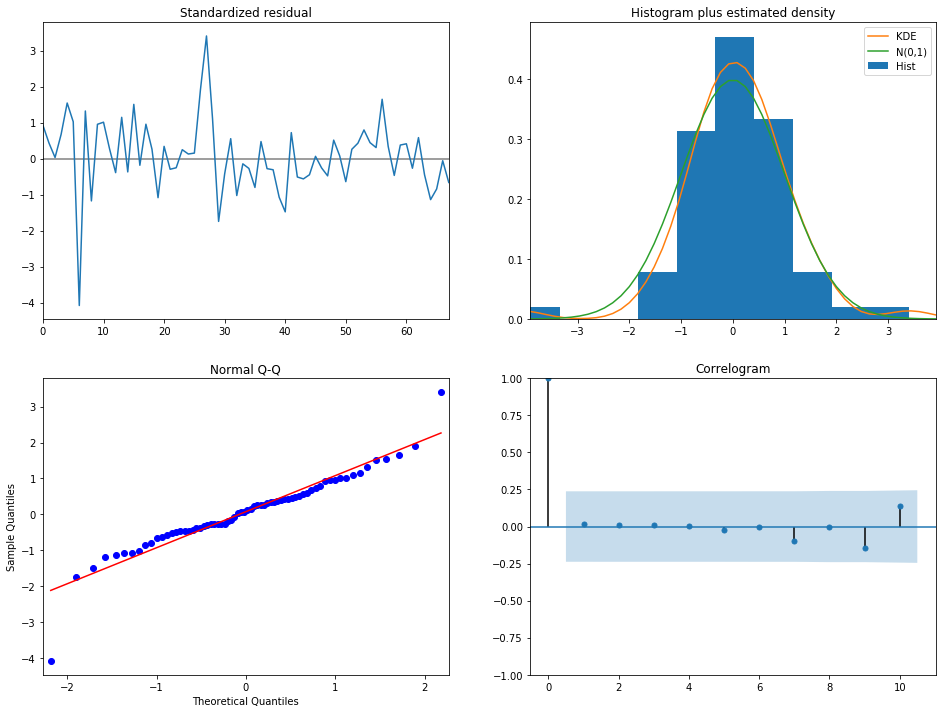

In [112]:
results.plot_diagnostics(figsize=(16,12));

### boxcox transformation with ARIMA (0,1,0)

In [113]:
model = SARIMAX(data_transformed, order=(0,1,0), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_prediction(start=-35)

In [114]:
prediction =inv_boxcox(forecast.predicted_mean, lam)

In [115]:
rmse = sqrt(mean_squared_error(test.Water, prediction))
print('RMSE: %.3f' % rmse)

RMSE: 22.087


In [116]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -67.474
Date:                Mon, 27 Apr 2020   AIC                            138.948
Time:                        23:04:47   BIC                            143.387
Sample:                             0   HQIC                           140.707
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0536      0.083      0.643      0.520      -0.110       0.217
sigma2         0.4260      0.038     11.322      0.000       0.352       0.500
===================================================================================
Ljung-Box (Q):                       38.16   Jarque-Bera (JB):               124.28
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

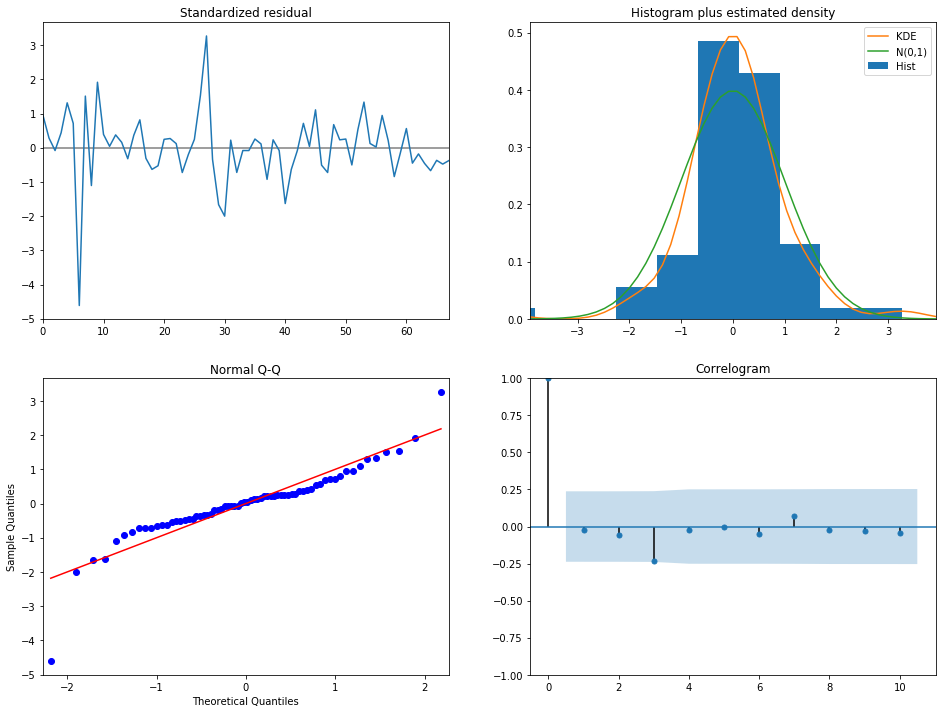

In [117]:
results.plot_diagnostics(figsize=(16,12));

### Forecasting out of sample

#### ARIMA (3,1,14)

In [180]:
model = SARIMAX(data, order=(3,1,14))

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=10)

In [181]:
rmse = sqrt(mean_squared_error(validation.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 91.485


In [136]:
validation.Water

Year
1954-01-01    568
1955-01-01    575
1956-01-01    579
1957-01-01    587
1958-01-01    602
1959-01-01    594
1960-01-01    587
1961-01-01    587
1962-01-01    625
1963-01-01    613
Name: Water, dtype: int64

In [137]:
forecast.predicted_mean

1954-01-01    543.604422
1955-01-01    533.284298
1956-01-01    522.025973
1957-01-01    542.002015
1958-01-01    544.323021
1959-01-01    528.880563
1960-01-01    514.945665
1961-01-01    482.418000
1962-01-01    454.316055
1963-01-01    460.490037
Freq: AS-JAN, dtype: float64

#### ARIMA (2,1,0)

In [169]:
model = SARIMAX(data, order=(2,1,0), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=10)

#### bias added !!!

In [170]:
forecast.predicted_mean = forecast.predicted_mean + bias

In [171]:
rmse = sqrt(mean_squared_error(validation.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 28.083


#### ARIMA (0,1,0)

In [152]:
model = SARIMAX(data, order=(0,1,0), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=10)

In [153]:
rmse = sqrt(mean_squared_error(validation.Water, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 40.522


#### ARIMA (3,1,14) with boxcox transformation

In [86]:
# Instantiate model
model = SARIMAX(data_transformed, order=(3,1,14))

results = model.fit()

# Make out-of-sample prediction
forecast_tr = results.get_forecast(steps=10)

In [87]:
forecast_normal = inv_boxcox(forecast_tr.predicted_mean, lam)

In [89]:
rmse = sqrt(mean_squared_error(validation.Water, forecast_normal))
print('RMSE: %.3f' % rmse)

RMSE: 63.067


#### ARIMA (2,1,0) with boxcox transformation

In [90]:
# Instantiate model
model = SARIMAX(data_transformed, order=(2,1,0))

results = model.fit()

# Make out-of-sample prediction
forecast_tr = results.get_forecast(steps=10)

In [91]:
forecast_normal = inv_boxcox(forecast_tr.predicted_mean, lam)

In [92]:
rmse = sqrt(mean_squared_error(validation.Water, forecast_normal))
print('RMSE: %.3f' % rmse)

RMSE: 54.807


##### ARIMA (2,1,0) bias added gives the best result!!! 

Source: Introduction to Time Series Forecasting with Python - Jason Brownlee